In [201]:
import numpy as np


from amalearn.agent import AgentBase
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import GaussianReward
import matplotlib.pyplot as plt

# A)

In [202]:
means = [2.5, 0.5, 1]
stds = [2, 1.5, 0.5]

rewards = [GaussianReward(mean, std) for mean, std in zip(means, stds)]
env = MutliArmedBanditEnvironment(rewards, 1000, '1')

In [203]:
def utility_function(reward, alpha, beta, lambdaa):
    if reward < 0:
        return -lambdaa * np.power((-reward),beta)
        
    else:
        return np.power(reward, alpha)

# B)

In [204]:
class GradientBanditAgent(AgentBase):
    def __init__(self, id, environment, alpha, a, b, l):
        super(GradientBanditAgent, self).__init__(id, environment)
        self.a = a
        self.b = b
        self.l = l
        self.available_actions = self.environment.available_actions()
        self.H = np.zeros(self.available_actions)
        self.rewards = []
        self.reward_mean = 0.0
        self.alpha = alpha

       
    def take_action(self) -> (object, float, bool, object):
        probabilities = self.softmax_preferences()
        action = np.random.choice(self.available_actions, p=probabilities)
        obs, r, d, i = self.environment.step(action)
        r = utility_function(r,self.a,self.b,self.l)
        self.update(r, action, probabilities)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i
    
    
    def softmax_preferences(self):
        probabilities = np.exp(self.H) / np.sum(np.exp(self.H))
        return probabilities
        

    def reset(self):
        self.H = np.zeros(self.available_actions)
        self.rewards = []
        self.reward_mean = 0.0

    def update(self, current_reward, taken_action, probabilities):
  
        # update pereference        
        self.H[taken_action] = self.H[taken_action] + self.alpha * (current_reward - self.reward_mean) * (1 - probabilities[taken_action])
        not_taken_actions = self.available_actions != taken_action
        self.H[not_taken_actions] = self.H[not_taken_actions] - self.alpha * (current_reward - self.reward_mean) * (probabilities[not_taken_actions])


        # update reward mean
        self.rewards.append(current_reward)
        self.reward_mean = np.mean(self.rewards)

In [205]:
class UCBBanditAgent(AgentBase):
    def __init__(self, id, environment, confidence_level, a, b, l):
        super(UCBBanditAgent, self).__init__(id, environment)
        self.confidence_level = confidence_level
        self.a = a
        self.b = b
        self.l = l
        self.available_actions = self.environment.available_actions()
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)
        self.rewards_variance = np.zeros(self.available_actions)
        self.actions_sum = np.zeros(self.available_actions)


    def take_action(self) -> (object, float, bool, object):
        t = self.environment.state['length'] + 1
        
        action = self.take_best_action(t)
        obs, r, d, i = self.environment.step(action)
        r = utility_function(r,self.a,self.b,self.l)
        self.update(r, action, t)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i

    def take_best_action(self, t):
        
        #exploitation = self.rewards_mean
        #exploration = self.confidence_level * np.sqrt(np.log(t) / self.actions_sum_sanitizer())
        #ucb_term = exploitation + exploration           
        
        fano_factor = self.rewards_mean / self.rewards_variance_sanitizer()
        
        exploitation = fano_factor
        exploration = self.confidence_level * np.sqrt(np.log(t) / self.actions_sum_sanitizer())
        ucb_term = exploitation + exploration   
        action = np.argmax(ucb_term)
        return action

    def reset(self):
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)
        self.rewards_variance = np.zeros(self.available_actions)
        self.actions_sum = np.zeros(self.available_actions)


    def update(self, reward, action, t):
        if(t < 20):
            self.rewards_history[action].append(reward)
            self.rewards_mean[action] = np.mean(self.rewards_history[action])
            self.rewards_variance[action] = np.var(self.rewards_history[action])
            
        else:
            self.rewards_history[action].append(reward)
            self.rewards_mean[action] = np.mean(self.rewards_history[action][-20:])
            self.rewards_variance[action] = np.var(self.rewards_history[action][-20:])
            
        self.actions_sum[action] += 1
        
    def rewards_variance_sanitizer(self):
        eps = np.finfo(np.float32).eps
        return np.where(self.rewards_variance == 0, eps, self.rewards_variance)
    
    def actions_sum_sanitizer(self):
        eps = np.finfo(np.float32).eps
        return np.where(self.actions_sum == 0, eps, self.actions_sum)

# C)

In [206]:
def agent_run(agent, env, run, trial):
    mean_reward = np.zeros(trial)
    for run in range(1, run+1):
        for step in range(trial):
            obs, r, d, i = agent.take_action()
            mean_reward[step] = ((run - 1) / run) * mean_reward[step] + ( 1 / run) * r

        env.reset()
        agent.reset()

    return mean_reward

In [207]:
def get_optimal_reward(run, trial):
    best_mean = np.max(means)
    arg_best_mean = np.argmax(means)
    reward = GaussianReward(best_mean, stds[arg_best_mean])
    
    best_reward = np.zeros(trial)
    for run in range(1, run+1):
        for step in range(trial):
            r = reward.get_reward()
            best_reward[step] = ((run - 1) / run) * best_reward[step] + ( 1 / run) * r
        
    return best_reward

optimal_reward = get_optimal_reward(20, 1000)
len(optimal_reward)

1000

In [208]:
gradient_agent = GradientBanditAgent('1', env, 0.1, 1, 1, 1)
grad_mean_reward = agent_run(gradient_agent, env, 20, 1000)
regret = optimal_reward - grad_mean_reward

print("trial 50: ", regret[49])
print("trial 100: ", regret[99])
print("trial 200: ", regret[199])

trial 50:  0.6772477951447664
trial 100:  -0.2380560217355301
trial 200:  -0.5643394320601796


In [209]:
ucb_agent = UCBBanditAgent('1', env, 2.0, 1, 1, 1)
ucb_mean_reward = agent_run(ucb_agent, env, 20, 1000)
regret = optimal_reward - ucb_mean_reward

print("trial 50: ", regret[49])
print("trial 100: ", regret[99])
print("trial 200: ", regret[199])

trial 50:  1.3570216978533343
trial 100:  1.5942285963762715
trial 200:  1.0501757044499513


# D)

In [210]:
def plot_mean_reward(grad_mean_reward, ucb_mean_reward, label):
    step_no = np.arange(len(grad_mean_reward))
    plt.figure(figsize=(16, 8))
    plt.plot(step_no, grad_mean_reward, label="Gradient")
    plt.plot(step_no, ucb_mean_reward, label="UCB")
    plt.xlabel("Steps")
    plt.ylabel(label + " Mean Reward")
    #plt.ylim([lower, upper])
    #new_list = range(int(np.floor(np.min(lower))), int(np.ceil(np.max(upper))+1))
    #plt.yticks(new_list)
    plt.legend(fontsize='large')
    plt.show();

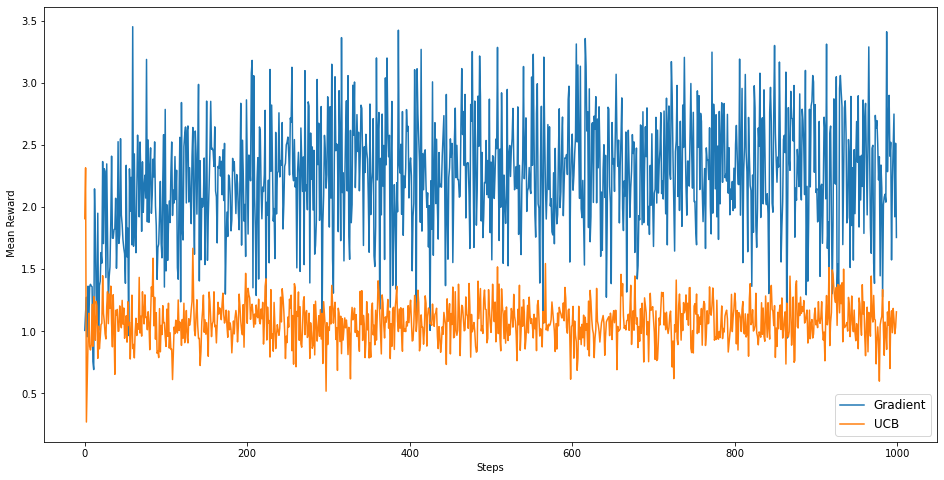

In [211]:
plot_mean_reward(grad_mean_reward, ucb_mean_reward, "")

In [212]:
grad_expected_return = np.mean(grad_mean_reward)
ucb_expected_return = np.mean(ucb_mean_reward)

print("Gradient Expected Return: ", grad_expected_return)
print("UCB Expected Return: ", ucb_expected_return)

Gradient Expected Return:  2.242740580245543
UCB Expected Return:  1.0770374092357728


# E)

In [213]:
gradient_agent = GradientBanditAgent('1', env, 0.1, 0.88, 0.88, 2.25)
grad_mean_reward = agent_run(gradient_agent, env, 20, 1000)

ucb_agent = UCBBanditAgent('1', env, 2.0, 0.88, 0.88, 2.25)
ucb_mean_reward = agent_run(ucb_agent, env, 20, 1000)

In [214]:
def sliding_window(mean_reward, sliding_window):
    trial = len(mean_reward)
    sliding_mean_reward = np.zeros(trial - sliding_window + 1)

    for i in range(trial - sliding_window + 1):
        sliding_mean_reward[i] = np.mean(mean_reward[i: sliding_window+i])

    
    return sliding_mean_reward

In [215]:
grad_sliding_mean_reward = sliding_window(grad_mean_reward, 15)
ucb_sliding_mean_reward = sliding_window(ucb_mean_reward, 15)

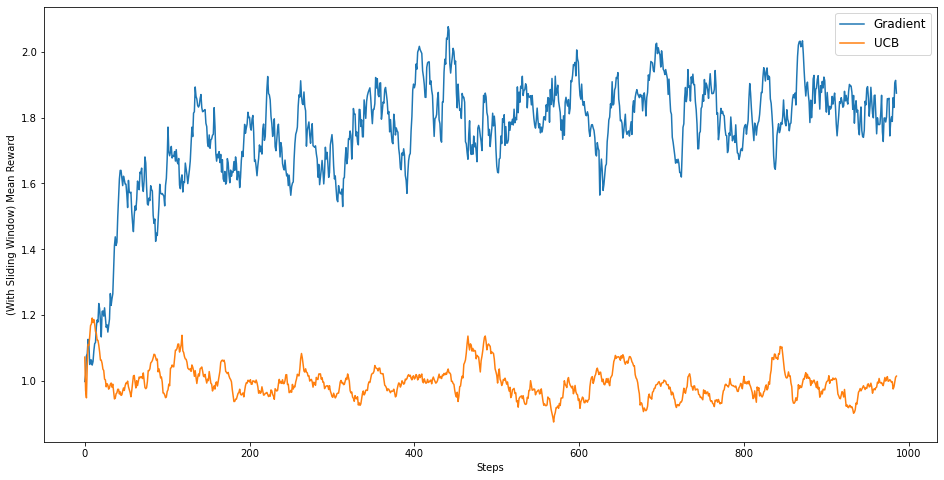

In [217]:
plot_mean_reward(grad_sliding_mean_reward, ucb_sliding_mean_reward, "(With Sliding Window)")